# Assignment 1

In this assignment we will build a multi layer neural network and train it to classify hand-written digits into 10 classes (digits 0-9).
We will use the [MNIST dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/) for training the classifier. The dataset is a good example of real-world data and is popular in the Machine Learning community. 
We will use PyTorch autograd functionality to estimate the gradient for gradient descent. 
Write you code in between

\### BEGIN SOLUTION ###

\### BEGIN SOLUTION ###

In [1]:
#import libraries and functions to load the data
from digits import get_mnist
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch.autograd import grad

## Load and Visualize Data

MNIST dataset contains grayscale samples of handwritten digits of size 28 $\times$ 28. It is split into training set of 60,000 examples, and a test set of 10,000 examples. 
The legacy code below will load the data into numpy arrays and then convert them to PyTorch tensors. 

trX.shape:  (784, 6000)
trY.shape:  (1, 6000)
tsX.shape:  (784, 10000)
tsY.shape:  (1, 10000)

Displaying a few samples
labels
[[0 9 0 5 0 7 0 0 5 6]
 [0 5 4 4 6 7 3 0 9 7]
 [8 8 8 7 6 2 2 1 9 6]
 [8 1 7 2 0 3 5 2 7 6]
 [1 0 6 3 8 0 4 1 5 5]
 [9 5 9 2 3 0 7 8 2 8]
 [9 7 1 4 0 1 4 2 5 5]
 [3 1 1 1 6 0 8 1 6 2]
 [1 1 2 2 4 6 0 1 0 7]
 [7 2 8 2 5 5 2 8 9 2]]

Corresponding images


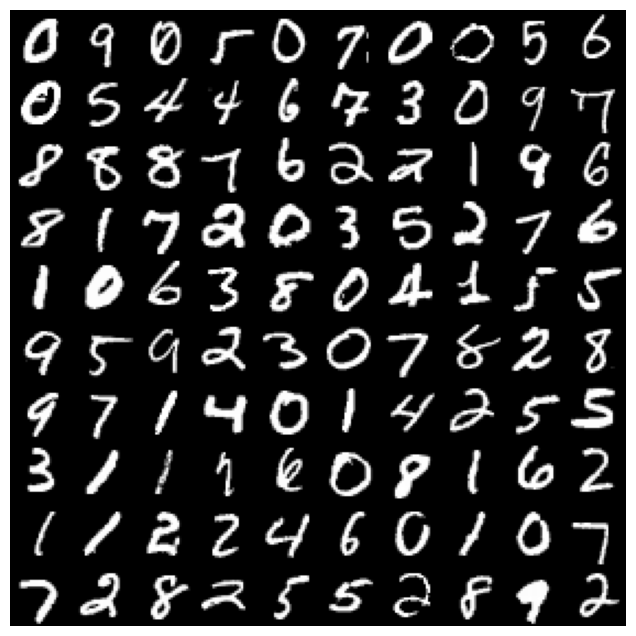

In [2]:
# The data is of the format (no_samples, channels, img_height, img_width)
# We will reshape it to (img_height*img_width, no_samples)
# In the training data trX, there are 60000 images. Each image has one channel (gray scale). 
# Each image is of height=28 and width=28 pixels
# We will use only 6000 training examples and all the 10000 test samples. 

def sample_mnist(n_train=2000, n_test=1000):
    trX, trY, tsX, tsY = get_mnist()
    #Shuffle the data.
    tr_idx = np.random.choice(trX.shape[0], n_train)
    trX = trX[tr_idx]
    trY = trY[tr_idx]
    ts_idx = np.random.choice(tsX.shape[0], n_test)
    tsX = tsX[ts_idx]
    tsY = tsY[ts_idx]
    # Reshape to [n x m]. n dimensions and m samples
    trX = trX.reshape(-1, 28*28).T
    trY = trY.reshape(1, -1)
    tsX = tsX.reshape(-1, 28*28).T
    tsY = tsY.reshape(1, -1)
    return trX, trY, tsX, tsY

# Lets verify the function
# Random seed for reproducibility
np.random.seed(1)
trX, trY, tsX, tsY = sample_mnist(n_train=6000, n_test=10000)
# Lets examine the data and see if it is normalized
print('trX.shape: ', trX.shape)
print('trY.shape: ', trY.shape)
print('tsX.shape: ', tsX.shape)
print('tsY.shape: ', tsY.shape)

# Let's visualize a few samples and their labels from the train and test datasets.
print('\nDisplaying a few samples')
visx = np.concatenate((trX[:,:50],tsX[:,:50]), axis=1).reshape(28,28,10,10).transpose(2,0,3,1).reshape(28*10,-1)
visy = np.concatenate((trY[:,:50],tsY[:,:50]), axis=1).reshape(10,-1)
print('labels')
print(visy)
print('\nCorresponding images')
plt.figure(figsize = (8,8))
plt.axis('off')
plt.imshow(visx, cmap='gray');

#convert numpy arrays to torch tensors becasue PyTorch autograd needs tensor format
trX = torch.tensor(trX, dtype=torch.float32)
trY = torch.tensor(trY, dtype=torch.int)
tsX = torch.tensor(tsX, dtype=torch.float32)
tsY = torch.tensor(tsY, dtype=torch.int)

### Activation Functions (15 points)

An Activation function adds nonlinearity to the output of a network layer using a mathematical operation. 
We will define the following nonlinear activations 
Rectified Linear Unit or ReLU 
Sigmoid 
Tanh

In [3]:
def relu(Z):
    '''
    Computes relu activation of input Z
    Inputs: 
        Z: torch tensor (n, m) which represent 'm' samples each of 'n' dimensions
    Outputs: 
        A: where A = relu(Z) is a torch tensor (n, m) representing 'm' samples each of 'n' dimensions
    '''
    # Hint: refer to torch.clamp()
    # Do not use torch.relu()
    ### BEGIN SOLUTION ###
    A = torch.clamp(Z, 0)
    ### END SOLUTION ###
    return A

In [4]:
def sigmoid(Z):
    '''
    Computes sigmoid activation of input Z
    Inputs: 
        Z: torch tensor (n, m) which represent 'm' samples each of 'n' dimensions
    Outputs: 
        A: where A = sigmoid(Z) is a torch tensor (n, m) representing 'm' samples each of 'n' dimensions
    '''
    # Hint: You can use torch.exp()
    # Do not use torch.sigmoid()
    ### BEGIN SOLUTION ###
    A = 1 / (1 + torch.exp(-Z))
    ### END SOLUTION ###
    return A

In [5]:
def tanh(Z):
    '''
    Computes tanh activation of input Z
    Inputs: 
        Z: torch tensor (n, m) which represent 'm' samples each of 'n' dimensions
    Outputs: 
        A: where A = tanh(Z) is a torch tensor (n, m) representing 'm' samples each of 'n' dimensions
    '''
    # Hint: You can use torch.exp()
    # Do not use torch.tanh()
    ### BEGIN SOLUTION ###
    (torch.exp(Z) + torch.exp(-Z)) / (torch.exp(-Z) + torch.exp(Z))
    
    ### END SOLUTION ###
    return A

### Softmax Activation  (10 points)

The softmax activation is computed on the outputs from the last layer and the output label with the maximum probablity is predicted as class label. The softmax function can be considered as a normalized exponential function which takes a vector of $n$ real numbers as input, and normalizes it into a probability distribution consisting of $n$ probabilities.

The input to the softmax function is the $(n \times m)$ matrix, $ Z = [ z^{(1)} , z^{(2)}, \ldots, z^{(m)} ] $, where $z^{(i)}$ is the $i^{th}$ sample of $n$ dimensions. We estimate the softmax for each of the samples $1$ to $m$. The softmax activation for sample $z^{(i)}$ is $a^{(i)} = \text{softmax}(z^{(i)})$, where the components of $a^{(i)}$ are,
\begin{equation}
a_k{(i)} = \frac{\text{exp}(z^{(i)}_k)}{\sum_{k = 1}^{n}\text{exp}(z^{(i)}_k)} \qquad \text{for} \quad 1\leq k\leq n
\end{equation}

The output of the softmax is $ A = [ a^{(1)} , a^{(2)} .... a^{(m)} ]$, where $a^{(i)} = [a^{(i)}_1,a^{(i)}_2, \ldots, a^{(i)}_n]^\top$.  In order to avoid floating point overflow, we subtract a constant from all the input components of $z^{(i)}$ before calculating the softmax. This constant is $z_{max}$, where, $z_{max} = \text{max}(z_1,z_2,...z_n)$ is the maximum value in a column. The activation is given by,

\begin{equation}
a_k{(i)} = \frac{\text{exp}(z^{(i)}_k- z_{max})}{\sum_{k = 1}^{n}\text{exp}(z^{(i)}_k - z_{max})} \qquad \text{for} \quad 1\leq k\leq n
\end{equation}

In [6]:
def softmax(Z):
    '''
    Computes the softmax activation of the inputs Z
    Inputs: 
        Z: torch tensor (n, m)
    Outputs:
        A: torch tensor (n, m) of softmax activations
    '''
    # Donot use torch.softmax()
    # Implement your own softmax using torch.exp()
    ### BEGIN SOLUTION ###
    z_max = torch.max(Z, 0).values
    Z -= z_max

    A = torch.exp(Z) / torch.sum(torch.exp(Z), 0)
    ### END SOLUTION ###
    return A

### Cross-entropy Loss Function (15 points) 

Cross-entropy is used for multi-category classification loss. If the output of softmax is given by $A$ and the ground truth is given by $Y = [ y^{(1)} , y^{(2)}, \ldots, y^{(m)}]$, the cross entropy loss between the predictions $A$ and groundtruth labels $Y$ is given by,

\begin{equation}
Loss(A,Y) = - \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^{n}I \{ y^i = k \} \text{log}a_k^i
\end{equation}


where $I$ is the identity function given by 

\begin{equation}
I\{\text{condition}\} = 1, \quad \text{if condition = True}\\
I\{\text{condition}\} = 0, \quad \text{if condition = False}\\
\end{equation}

In [7]:
def cross_entropy_loss(yhat, y):
    '''
    Estimates the cross entropy loss between predictions and groundtruth
    Inputs: 
        yhat: torch tensor (n, m) - probability output after Softmax activation
        y: torch tensor (1, m) of groundtruth labels 
    Outputs:
        loss: cross-entropy loss between predictions and groundtruth
    '''
    # Donot use torch.nn.CrossEntropyLoss
    # Implement your own cross entropy loss
    ### BEGIN SOLUTION ###
    m = yhat.size(dim=1)

    ## get one hot vector
    y = y.long() # required for F.one_hot
    one_hot = torch.nn.functional.one_hot(y)[0].T # get one hot vector

    ## avoid taking logs of 0 or 1
    epsilon = 1e-15
    yhat = torch.clamp(yhat, epsilon, 1 - epsilon)

    ## evaluate function

    # loss = yhat * one_hot
    # print(loss.dtype)
    # loss = torch.sum(loss, 0)
    # loss = torch.log(loss)
    # loss = torch.sum(loss)

    # for some reason using this method (taking log before multiplying with one hot vector) improves accuracy
    loss = torch.log(yhat)
    loss *= one_hot
    loss = torch.sum(loss)

    ## division
    loss /= -m
    ### END SOLUTION ###
    return loss

In [8]:
#Code to test your implementation of softmax() and cross_entropy_loss()
torch.manual_seed(1)
Z = torch.randn(3,4)
print(f"Z:\n {Z}")
Softmax_student = softmax(Z)
print(f"Student Softmax:\n {Softmax_student}")
Softmax_torch = torch.nn.functional.softmax(Z, dim=0)
print(f"PyTorch Softmax:\n {Softmax_torch}")
y_test = torch.tensor([[1., 0., 2., 0.]])
loss_student = cross_entropy_loss(Softmax_torch, y_test)
print(f"Student Cross_entropy:\n {loss_student}")
loss_torch = torch.nn.functional.cross_entropy(Z.T, y_test.view(-1).to(torch.int64))
print(f"PyTorch Softmax:\n {loss_torch}")
# The cross-entropy loss should match upto 5 or 6 significant decimal places. 

Z:
 tensor([[ 0.6614,  0.2669,  0.0617,  0.6213],
        [-0.4519, -0.1661, -1.5228,  0.3817],
        [-1.0276, -0.5631, -0.8923, -0.0583]])
Student Softmax:
 tensor([[0.6609, 0.4797, 0.6288, 0.4360],
        [0.2171, 0.3111, 0.1289, 0.3431],
        [0.1221, 0.2092, 0.2422, 0.2210]])
PyTorch Softmax:
 tensor([[0.6609, 0.4797, 0.6288, 0.4360],
        [0.2171, 0.3111, 0.1289, 0.3431],
        [0.1221, 0.2092, 0.2422, 0.2210]])
Student Cross_entropy:
 1.1275286674499512
PyTorch Softmax:
 1.1275286674499512


### Multi Layer Network Class (20 points)

We will define a class to model the fully connected multi layer network. 
The network parameters will be a dictionary accesssed with keys "W1", "b1", "W2", "b2", etc.

1. The weight matrix is initialized with random values from a normal distribution with variance $1$. For example, to create a matrix $w$ of dimension $3 \times 4$, with values from a normal distribution with variance $1$, we write `w = 0.01*torch.randn(3,4, requires_grad=True, dtype=torch.float32)`. The $0.01$ is to ensure very small values close to zero for faster training. The `requires_grad` will be needed for tracking gradient. We limit the precision to `torch.float32` (optional).

2. Bias values are initialized with 0. For example a bias vector of dimensions $3 \times 1$ is initialized as `b = torch.zeros((3,4),requires_grad=True, dtype=torch.float32)`

The dimension for weight matrix for layer $(l+1)$ is given by ( Number-of-neurons-in-layer-$(l+1)$   $\times$   Number-of-neurons-in-layer-$l$ ). The dimension of the bias for for layer $(l+1)$ is (Number-of-neurons-in-layer-$(l+1)$   $\times$   1)

In [9]:
class MultiLayerNetwork():
    def __init__(self, net_dims, activation_list=None):
        ## Activation functions can be provided through activation_list
        # Default activations are relu for all layers 
        # except for the last layer which is Softmax 
        self.allowed_activations = ['relu', 'sigmoid', 'tanh']
        self.final_activation = 'softmax'
        self.num_layers = len(net_dims)-1
        if activation_list is None:
            self.activation_list = ['relu']*(self.num_layers-1) + ['softmax']
        elif (len(activation_list)==self.num_layers and\
            all(act in self.allowed_activations for act in activation_list[:-1]) and\
            activation_list[-1] == 'softmax'):
            self.activation_list = activation_list
        else:    
            raise ValueError('activation_list is incorrect!')
        
        ## Intitialize parameters as a dictionary
        self.parameters = {}
        for ly in range(self.num_layers):
            # Hint:    
            # parameters["W"+str(ly+1)] = 0.01*torch.randn(.., ..)
            # parameters["b"+str(ly+1)] = torch.zeros((.., ..))
            # Use requires_grad=True, dtype=torch.float32 
            ### BEGIN SOLUTION ###
            self.parameters["W"+str(ly+1)] = 0.01*torch.randn(net_dims[ly+1], net_dims[ly], requires_grad=True, dtype=torch.float32)
            self.parameters["b"+str(ly+1)] = torch.zeros((net_dims[ly+1], 1), requires_grad=True, dtype=torch.float32)
            ### END SOLUTION ###
    
    ## Forward propagation of input data through the network
    def forward(self, x):
        for ly in range(self.num_layers):
            ## Apply the dot product followed by activation
            ## Use torch.mm()
            ### BEGIN SOLUTION ###
            x = torch.mm(self.parameters["W"+str(ly+1)], x)
            x += self.parameters["b"+str(ly+1)]
            x = eval(self.activation_list[ly])(x)
            ### END SOLUTION ###
        return x
    
    
    ## Function to Display the Network
    def display(self):
        print('%d Layer Fully Connected Neural Network' % self.num_layers)
        dims = list(self.parameters.values())
        for ly in range(self.num_layers):
            print('[W%s=(%dx%d),b%s=(%dx%d) + %s]===>' % \
                  (str(ly+1),dims[2*ly].shape[0],dims[2*ly].shape[1],\
                  str(ly+1),dims[2*ly+1].shape[0],dims[2*ly+1].shape[1],\
                  self.activation_list[ly]),end='')
        print('[Cross_entropy_loss]')

### Training (30 points)

The `train(...)` function will implement batch gradient descent to train the model. 
Use PyTorch autograd to estimate gradients and update parameters during gradient descent. 

In [10]:
def train(model, x, y, num_epochs=20, learning_rate=0.1, seed=1, log=False):
    cost = []
    
    torch.manual_seed(seed)
    for ii in range(num_epochs):

        ## Forward Propagation and loss ##
        ### BEGIN SOLUTION ###
        yhat = model.forward(x)
        
        loss = cross_entropy_loss(yhat, y)
        ### END SOLUTION ###

        ## Compute gradient and update parameters ##
        ## The grad(.) function gets the gradients of the loss w.r.t parameters in a list 
        ## The output gradients is a list of corresponding parameter gradients 
        gradients = grad(loss, list(model.parameters.values()))

        ## Whenever a parameter changes during an operation, 
        ## a graph is maintained to estimate the gradient 
        ## PyTorch does not allow to modify such 
        ## parameters in place (for e.g. assigning an arbitrary value to the parameter)
        ## Becasue such operations will not be able to estimate the gradient
        ## We therefore turn-off the gradient during parameter update 
        with torch.no_grad():
            for ly in range(model.num_layers):
                ## Access the gradients list to get dw and db 
                ## and update parameters using -learing_rate*dw and -learing_rate*db
                ## For e.g. 
                ## gradients[0] is the gradient for W1
                ## gradients[1] is the gradient for b1
                ## gradients[2] is the gradient for W2
                ## gradients[3] is the gradient for b2
                ## gradients[2*ly] is the gradient for W(ly+1)
                ## gradients[2*ly+1] is the gradient for b(ly+1)
                ### BEGIN SOLUTION ###
                model.parameters["W"+str(ly+1)] -= learning_rate*gradients[2*ly]
                model.parameters["b"+str(ly+1)] -= learning_rate*gradients[2*ly+1]
                ### END SOLUTION ###

        ## Print loss every epoch ##
        ## We do not need to track gradient during the evaluation
        cost.append(loss.detach())
        if not ii%20:
            print('Epoch: %02d | Loss: %.5f' % ((ii+1),loss))

    return cost

### Evaluation  (10 points)

We will intialize `model` using the `MultiLayerNetwork()` and train the model with the `train()` method 
We will display the training and plot the traing loss

2 Layer Fully Connected Neural Network
[W1=(200x784),b1=(200x1) + relu]===>[W2=(10x200),b2=(10x1) + softmax]===>[Cross_entropy_loss]
Epoch: 01 | Loss: 2.30487


Epoch: 21 | Loss: 1.75080
Epoch: 41 | Loss: 1.11524
Epoch: 61 | Loss: 0.63701
Epoch: 81 | Loss: 0.59412
Epoch: 101 | Loss: 0.52119
Epoch: 121 | Loss: 0.42881
Epoch: 141 | Loss: 0.41183
Epoch: 161 | Loss: 0.36019
Epoch: 181 | Loss: 0.33665
Epoch: 201 | Loss: 0.33510
Epoch: 221 | Loss: 0.30936
Epoch: 241 | Loss: 0.29419
Epoch: 261 | Loss: 0.28586
Epoch: 281 | Loss: 0.28022
Accuracy for training set is 92.400 %
Accuracy for testing set is 91.120 %


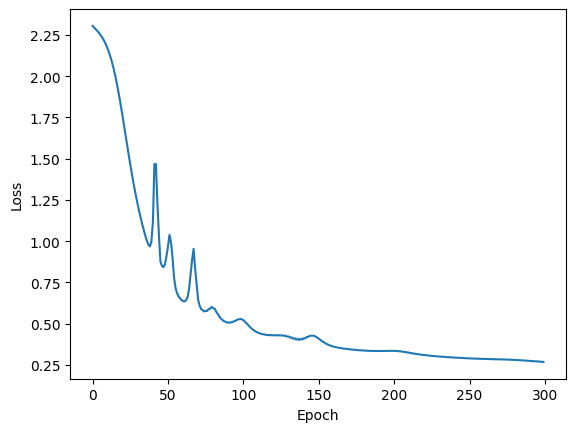

In [11]:
# You should be able to get a train accuracy of >91% and a test accuracy >90% 
# The settings below gave >92% train accuracy and >91% test accuracy 
# Feel free to adjust the values and the architecture 
# Keep the network to <= 4 layers and num_epochs <= 500 

seed = 1
torch.manual_seed(seed)
num_epochs=300
learning_rate=0.1

net_dims = [784,200,10] 
# 2 layer network
#784 is for image dimensions
#200 is arbitrary hidden layer
#10 is for number of categories 
#activation_list = ['relu', 'softmax'] #default activation.

## Initialize model 
## Display model
## Estimate cost as the output of train(....)
### BEGIN SOLUTION ###
model = MultiLayerNetwork(net_dims)
model.display()
cost = train(model, trX, trY, num_epochs, learning_rate, seed)
### END SOLUTION ###

yhat = model.forward(trX)
ypred = torch.argmax(yhat,axis = 0).reshape(1,-1)
trAcc = torch.mean((ypred == trY).float())*100
yhat = model.forward(tsX)
ypred = torch.argmax(yhat,axis = 0).reshape(1,-1)
tsAcc = torch.mean((ypred == tsY).float())*100
print("Accuracy for training set is {0:0.3f} %".format(trAcc))
print("Accuracy for testing set is {0:0.3f} %".format(tsAcc))

plt.plot(range(len(cost)), cost)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Congratulations! This completes the assignment.